[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) for MNIST
(J. Ho, A. Jain, P. Abbeel 2020)

![](https://raw.githubusercontent.com/dataflowr/website/master/modules/extras/diffusions/ddpm.png)


Given a schedule $\beta_1<\beta_2<\dots <\beta_T$, the **forward diffusion process** is defined by:
$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1},\beta_t I)$ and $q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})$.

With $\alpha_t = 1-\beta_t$ and $\overline{\alpha_t} = \prod_{i=1}^t\alpha_i$, we see that, with $\epsilon\sim\mathcal{N}(0,I)$:
\begin{align*}
x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\epsilon.
\end{align*}
The law $q(x_{t-1}|x_t,\epsilon)$ is explicit: $q(x_{t-1}|x_t,\epsilon) = \mathcal{N}(x_{t-1};\mu(x_t,\epsilon,t), \gamma_t I)$ with,
\begin{align*}
\mu(x_t,\epsilon, t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon\right)\text{ and, }
\gamma_t = \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_{t}}\beta_t
\end{align*}


**Training**: to approximate **the reversed diffusion** $q(x_{t-1}|x_t)$ by a neural network given by $p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t,t), \beta_t I)$ and $p(x_T) \sim \mathcal{N}(0,I)$, we maximize the usual Variational bound:
\begin{align*}
\mathbb{E}_{q(x_0)} \ln p_{\theta}(x_0) &\geq L_T +\sum_{t=2}^T L_{t-1}+L_0 \text{ with, }L_{t-1} = \mathbb{E}_q\left[ \frac{1}{2\sigma_t^2}\|\mu_\theta(x_t,t) -\mu(x_t,\epsilon,t)\|^2\right].
\end{align*}
With the change of variable:
\begin{align*}
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right),
\end{align*}
ignoring the prefactor and sampling $\tau$ instead of summing over all $t$, the loss is finally:
\begin{align*}
\ell(\theta) = \mathbb{E}_\tau\mathbb{E}_\epsilon \left[ \|\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_\tau}x_0 + \sqrt{1-\overline{\alpha}_\tau}\epsilon, \tau)\|^2\right]
\end{align*}



**Sampling**: to simulate the reversed diffusion with the learned $\epsilon_\theta(x_t,t)$ starting from $x_T\sim \mathcal{N}(0,I)$, iterate for $t=T,\dots, 1$:
\begin{align*}
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right)+\sqrt{\beta_t}\epsilon,\text{ with } \epsilon\sim\mathcal{N}(0,I).
\end{align*}

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

In [2]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [im.permute(1,2,0).numpy() for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [5]:
class MyConv(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyConv, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out

def MyTinyBlock(size, in_c, out_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, out_c),
                         MyConv((out_c, size, size), out_c, out_c),
                         MyConv((out_c, size, size), out_c, out_c))

def MyTinyUp(size, in_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, in_c//2),
                         MyConv((in_c//2, size, size), in_c//2, in_c//4),
                         MyConv((in_c//4, size, size), in_c//4, in_c//4))

In [6]:
class MyTinyUNet(nn.Module):
  # Here is a network with 3 down and 3 up with the tiny block
    def __init__(self, in_c=1, out_c=1, size=32, n_steps=1000, time_emb_dim=100):
        super(MyTinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = MyTinyBlock(size, in_c, 10)
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)
        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = MyTinyBlock(size//2, 10, 20)
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)
        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = MyTinyBlock(size//4, 20, 40)
        self.down3 = nn.Conv2d(40, 40, 4, 2, 1)

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyConv((40, size//8, size//8), 40, 20),
            MyConv((20, size//8, size//8), 20, 20),
            MyConv((20, size//8, size//8), 20, 40)
        )

        # Second half
        self.up1 = nn.ConvTranspose2d(40, 40, 4, 2, 1)
        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = MyTinyUp(size//4, 80)
        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = MyTinyUp(size//2, 40)
        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = MyTinyBlock(size, 20, 10)
        self.conv_out = nn.Conv2d(10, out_c, 3, 1, 1)

    def forward(self, x, t): # x is (bs, in_c, size, size) t is (bs)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (bs, 20, size/4, size/4)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (bs, 80, size/8, size/8)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (bs, 20, size/8, size/8)
        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (bs, 40, size/4, size/4)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out = torch.cat((out1, self.up3(out5)), dim=1)  # (bs, 20, size, size)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (bs, 10, size, size)
        out = self.conv_out(out) # (bs, out_c, size, size)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))

In [7]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial
import math
from einops import rearrange


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)


def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ConvNextBlock, mult=convnext_mult)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)


In [ ]:
!pip install einops

The `MyTinyUNet` is a versy small implementation of a convolutional UNet where a time embedding has been added at each step. To make things simple, we need to have an image of size $s\times s$ with $s$ divisible by 8 (this is why we will increase the size of the MNIST dataset from $28\times 28$ to $32 \times 32$).

In [7]:
bs = 3
x = torch.randn(bs,1,32,32)
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = MyTinyUNet(in_c =1, out_c =1, size=32)

In [8]:
y = unet(x,timesteps)
y.shape

torch.Size([3, 1, 32, 32])

In [9]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

In [64]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device, scheduling_improved = False) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        if scheduling_improved:
              s = 0.008
              steps = num_timesteps+1
              x = torch.linspace(0, num_timesteps, steps)
              alphas_cumprod = torch.cos(((x / num_timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
              self.alphas_cumprod = (alphas_cumprod / alphas_cumprod[0]).to(device)

              self.betas = (1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])).to(device)
              self.betas = torch.clip(self.betas, 0.0001, 0.9999)
              self.alphas_cumprod = ((alphas_cumprod / alphas_cumprod[0])[:-1]).to(device)
              self.alphas = (1.0 - self.betas).to(device)
        else:
            self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
            self.alphas = 1.0 - self.betas
            self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = (self.alphas_cumprod ** 0.5).to(device) # used in add_noise
        self.sqrt_one_minus_alphas_cumprod = ((1 - self.alphas_cumprod) ** 0.5).to(device) # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        # x_start and x_noise (bs, n_c, w, d)
        # timesteps (bs)
        coef1 = self.sqrt_alphas_cumprod[timesteps]
        coef2 = self.sqrt_one_minus_alphas_cumprod[timesteps]
        coef1 = coef1.view(-1,1,1,1)
        coef2 = coef2.view(-1,1,1,1)
        return coef1* x_start + coef2 * x_noise
    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)

    def step(self, model_output, timestep, sample):
        # one step of sampling
        # timestep (1)

        coef1 = (1/self.alphas ** 0.5)[timestep].view(-1,1,1,1)
        coef2 = ((1-self.alphas)/self.sqrt_one_minus_alphas_cumprod)
        coef2 = coef2[timestep].view(-1,1,1,1)

        if timestep == 0:
            coef3 = torch.zeros_like(self.betas[timestep]).view(-1,1,1,1)
        else:
            coef3 = self.betas[timestep] *(1-self.alphas_cumprod[timestep-1])/(1-self.alphas_cumprod[timestep])
            coef3 = coef3.view(-1, 1, 1, 1)
        coef4= self.betas[timestep].view(-1,1,1,1)
        return coef1*(sample - coef2*model_output) + torch.sqrt(coef3)*torch.randn_like(sample)


The commands below are here to help you and to test your code.

In [12]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

In [13]:

betas[timesteps]

tensor([0.0142, 0.0090, 0.0112], device='cuda:0')

In [14]:
betas[10]

tensor(0.0003, device='cuda:0')

In [15]:
betas[timesteps].reshape(-1,1,1,1).shape

torch.Size([3, 1, 1, 1])

In [16]:
network = MyTinyUNet(in_c =1, out_c =1, size=32)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)

In [17]:
bs = 5
x = torch.randn(bs,1,32,32).to(device)
timesteps = 10*torch.ones(bs,).long().long().to(device)

In [18]:
timesteps.shape

torch.Size([5])

In [19]:
y = model.add_noise(x,x,timesteps)
y.shape

torch.Size([5, 1, 32, 32])

In [20]:
y = model.step(x,timesteps[0],x)
y.shape

torch.Size([5, 1, 32, 32])

You can check that all the parameters of the UNet `network` are indeed parameters of the DDPM `model` like this:

In [ ]:
for n, p in model.named_parameters():
    print(n, p.shape)

network.time_embed.weight torch.Size([1000, 100])
network.te1.0.weight torch.Size([1, 100])
network.te1.0.bias torch.Size([1])
network.te1.2.weight torch.Size([1, 1])
network.te1.2.bias torch.Size([1])
network.b1.0.ln.weight torch.Size([1, 32, 32])
network.b1.0.ln.bias torch.Size([1, 32, 32])
network.b1.0.conv1.weight torch.Size([10, 1, 3, 3])
network.b1.0.conv1.bias torch.Size([10])
network.b1.1.ln.weight torch.Size([10, 32, 32])
network.b1.1.ln.bias torch.Size([10, 32, 32])
network.b1.1.conv1.weight torch.Size([10, 10, 3, 3])
network.b1.1.conv1.bias torch.Size([10])
network.b1.2.ln.weight torch.Size([10, 32, 32])
network.b1.2.ln.bias torch.Size([10, 32, 32])
network.b1.2.conv1.weight torch.Size([10, 10, 3, 3])
network.b1.2.conv1.bias torch.Size([10])
network.down1.weight torch.Size([10, 10, 4, 4])
network.down1.bias torch.Size([10])
network.te2.0.weight torch.Size([10, 100])
network.te2.0.bias torch.Size([10])
network.te2.2.weight torch.Size([10, 10])
network.te2.2.bias torch.Size([1

In [11]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    """Training loop for DDPM"""

    global_step = 0
    losses = []

    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)

            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)
            x_start = batch
            noise = torch.randn_like(x_start).to(device)
            x_noise = model.add_noise(x_start, noise, timesteps)
            model_output = model.reverse(x_noise, timesteps)

            loss = F.mse_loss(model_output, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1

        progress_bar.close()

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Your stop method has been called.*")

root_dir = './data/'
transform01 = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])


dataset = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transform01, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=4096, shuffle=True, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


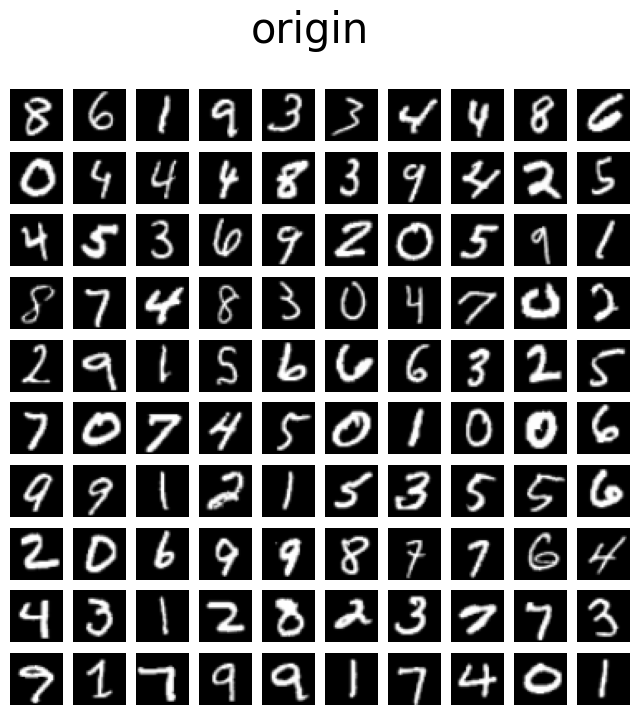

In [23]:
for b in dataloader:
    batch = b[0]
    break

bn = [b for b in batch[:100]]
show_images(bn, "origin")

In [70]:
learning_rate = 1e-3
num_epochs = 50
num_timesteps = 1000
network = MyTinyUNet()
network = network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device, scheduling_improved=True)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [71]:
torch.save({
    'model_state_dict': network.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'ddpm_model2.pth')

In [47]:
network = MyTinyUNet()
network = network.to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
num_timesteps = 1000
# Chargez l'état sauvegardé
checkpoint = torch.load('ddpm_model2.pth', map_location=device)
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


learning_rate = 1e-3
num_epochs = 1

model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device,scheduling_improved=True )
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)

FileNotFoundError: [Errno 2] No such file or directory: 'ddpm_model2.pth'

In [34]:
def generate_image(ddpm, sample_size, channel, size):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)

        for i, t in enumerate(tqdm(timesteps)):
            timestep = torch.full((sample_size, 1), t, dtype=torch.long, device=device)
            predicted_noise = ddpm.reverse(sample, timestep)
            sample = ddpm.step(predicted_noise, timestep[0], sample)
            if t==500:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

In [72]:
generated, generated_mid = generate_image(model, 100, 1, 32)

  0%|          | 0/1000 [00:00<?, ?it/s]

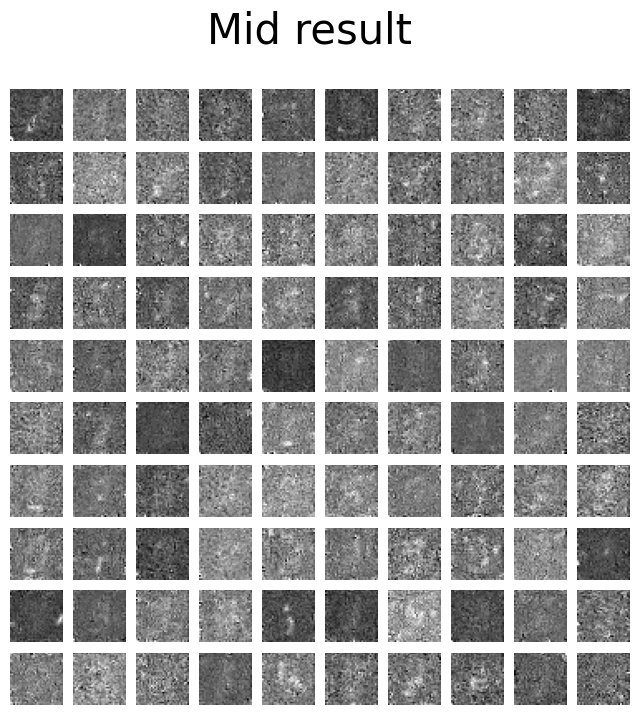

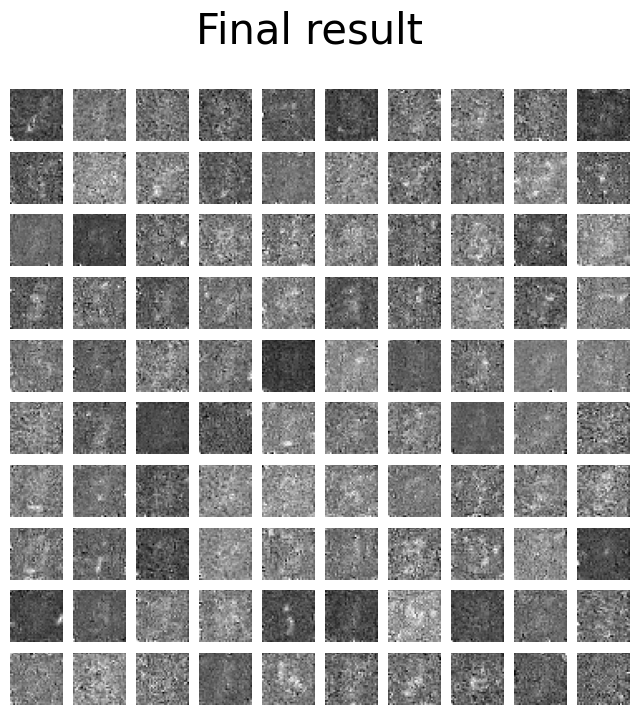

In [73]:
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")


In [ ]:
# torch.cuda.empty_cache()

# learning_rate = 1e-3
# num_epochs = 50
# num_timesteps = 1000
# network_im = Unet(
#     dim=28,
#     init_dim=None,
#     out_dim=None,
#     dim_mults=(1, 2, 4),
#     channels=1,
#     with_time_emb=True,
#     convnext_mult=2,
# )
# network_im = network_im.to(device)
# model_im = DDPM(network_im, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device, scheduling_improved=True)
# optimizer = torch.optim.Adam(network_im.parameters(), lr=learning_rate)
# training_loop(model_im, dataloader, optimizer, num_epochs, num_timesteps, device=device)

learning_rate = 1e-3
num_epochs = 50
num_timesteps = 1000
network = MyTinyUNet()
network = network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device, scheduling_improved=False)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

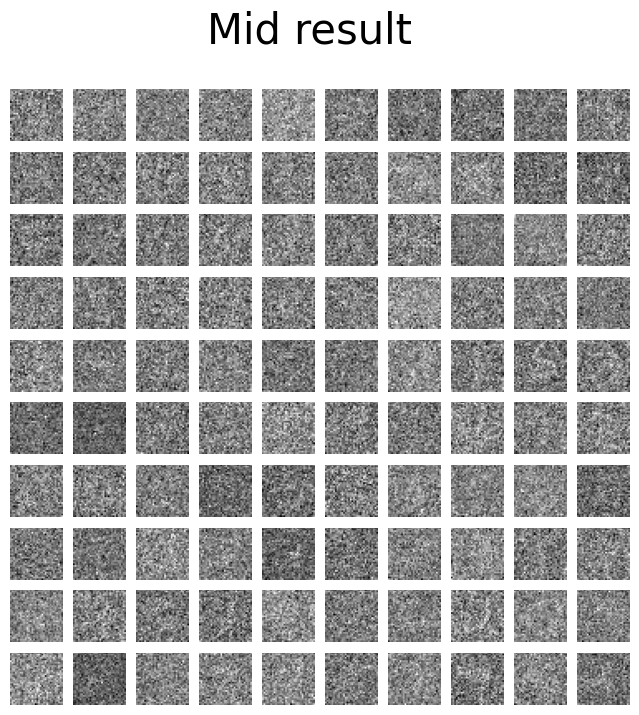

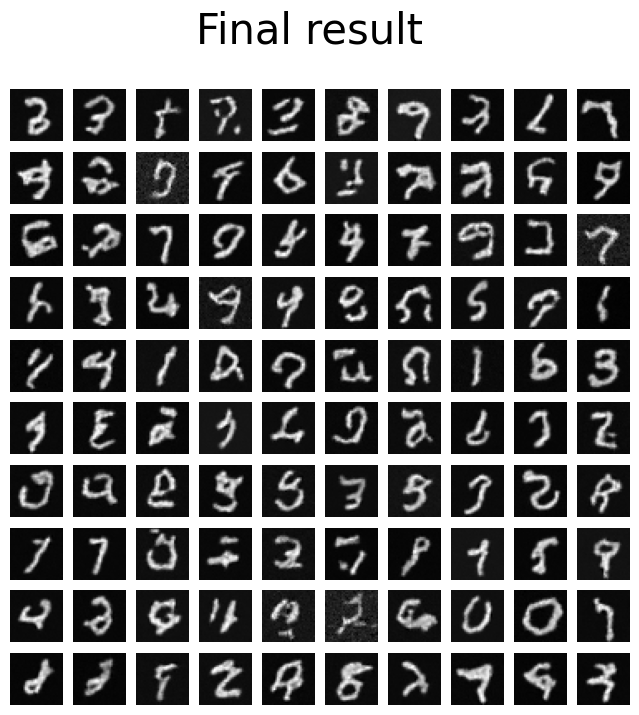

In [ ]:
generated, generated_mid = generate_image(model, 100, 1, 32)
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")
